# Dependency
Install the shap module.

In [ ]:
!pip install shap
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1RBAjHt-iO1LFAYQMbwfxE6hDw-VdljHE" -O train.json && rm -rf /tmp/cookies.txt

import json
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from textblob import TextBlob
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from tqdm.notebook import tqdm
tqdm.pandas()
import pdb

# Feature Engineering

In [2]:
# Sample 1000 data from the training set
with open('train.json') as json_file:
    data = json.load(json_file)
df = pd.DataFrame.from_records(data).sample(n=1000, random_state=0)

# Create features from text and reply
def _preprocess(data):

  # Length
  data['text_word_count'] = len(data['text'].split())

  # Polarity and subjectivity
  textblob = TextBlob(data['text'])
  data['text_pol'] = textblob.sentiment.polarity
  data['text_sub'] = textblob.sentiment.subjectivity

  # POS count
  pos_dict = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
  } 
  def _pos_count(text, type):
    count = 0
    for (word, pos) in TextBlob(text).tags:
      if pos in pos_dict[type]:
        count += 1
    return count
  data['text_adj_count'] = _pos_count(data['text'], 'adj')
  data['reply_adj_count'] = _pos_count(data['reply'], 'adj')
  data['text_adv_count'] = _pos_count(data['text'], 'adv')
  data['reply_adv_count'] = _pos_count(data['reply'], 'adv')

  # [TODO 1] Create at least 5 features. ###########
  # E.g. Length of reply, sentiment polarity, ...

  ## 1. categories count
  data['categories_count'] = len(data['categories'])
  ## 2. the ratio of reply to text
  data['reply2text_word_count_ratio'] = len(data['reply'].split())/len(data['text'].split())
  ## 3. the total of reply and text word count
  data['replyandtext_word_count'] = len(data['reply'].split())+len(data['text'].split())
  ## 4. sum of text polarity and reply polarity
  replyblob = TextBlob(data['reply'])
  data['reply_pol'] = replyblob.sentiment.polarity
  data['reply_sub'] = replyblob.sentiment.subjectivity
  data['textandreply_pol'] = data['text_pol'] + data['reply_pol']
  ## 5. sum of text subjectivity and reply subjectivity
  data['textandreply_sub'] = data['text_sub'] + data['reply_sub']

  ##################################################

  data['label'] = 1 if data['label']=='real' else 0
  return data

df = df.progress_apply(lambda x: _preprocess(x), axis=1)

# Take labels and remove unused columns in data
labels = df['label'].to_numpy()
df = df.drop(columns=['idx', 'text', 'categories', 'context_idx', 'reply', 'mp4', 'label'])

# Split the dataset for training and validation
X_train,X_test,Y_train,Y_test = train_test_split(*(df, labels), test_size=0.2, random_state=0)

In [3]:
df.head()

,text_word_count,text_pol,text_sub,text_adj_count,reply_adj_count,text_adv_count,reply_adv_count,categories_count,reply2text_word_count_ratio,replyandtext_word_count,reply_pol,reply_sub,textandreply_pol,textandreply_sub
27898,17,-0.500000,0.550000,2,1,0,0,0,0.117647,19,0.0,0.0,-0.500000,0.550000
103596,17,0.625000,0.500000,3,1,0,0,0,0.529412,26,-0.2,0.8,0.425000,1.300000
75381,43,-0.125000,0.455000,5,1,2,0,0,0.093023,47,0.8,0.7,0.675000,1.155000
145913,32,0.308333,0.391667,2,0,2,0,1,0.000000,32,0.0,0.0,0.308333,0.391667
67238,41,0.500000,0.500000,2,1,1,0,0,0.195122,49,0.0,0.0,0.500000,0.500000


In [4]:
df = df[['categories_count','reply2text_word_count_ratio','replyandtext_word_count','textandreply_pol','textandreply_sub']]

In [5]:
df.head()
# Split the dataset for training and validation
X_train,X_test,Y_train,Y_test = train_test_split(*(df, labels), test_size=0.2, random_state=0)

# Model Leanring


## For SVM 

In [6]:
# Train a SVM classifier
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)
print(f"SVC Test Accuracy: {accuracy_score(Y_test, svm.predict(X_test))}")
print(f"SVC Test Loss: {log_loss(Y_test, svm.predict_proba(X_test))}")

SVC Test Accuracy: 0.88
SVC Test Loss: 0.31407967071077003


## For Random Forest

In [7]:
# Train a Random Forest classifier
rfc = sklearn.ensemble.RandomForestClassifier(max_depth=2, random_state=0)
rfc.fit(X_train, Y_train)
print(f"Random Forest Test Accuracy: {accuracy_score(Y_test, rfc.predict(X_test))}")
print(f"Random Forest Test Loss: {log_loss(Y_test, rfc.predict_proba(X_test))}")

Random Forest Test Accuracy: 0.96
Random Forest Test Loss: 0.10462541599305282


## For XGBoost

In [8]:
import xgboost

# Train a XGBoost classifier
xgb = xgboost.XGBClassifier(objective='binary:logistic', n_estimators=2)
xgb.fit(X_train, Y_train)
print(f"XGB Test Accuracy: {accuracy_score(Y_test, xgb.predict(X_test))}")
print(f"XGB Test Loss: {log_loss(Y_test, xgb.predict_proba(X_test))}")

XGB Test Accuracy: 0.96
XGB Test Loss: 0.5363216903805733


# Explaination

## For SVC

In [9]:
##### For SVC #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, shap.kmeans(X_train, 100)) # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=50)

In [10]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

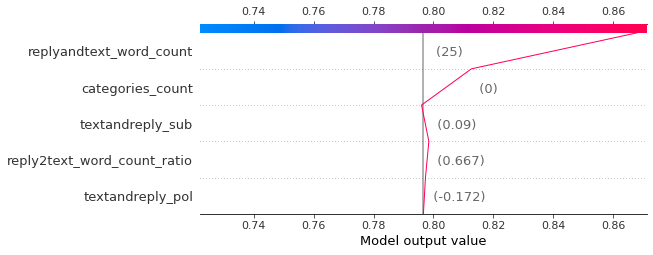

In [11]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

## For Random Forest

In [13]:
##### For RFC #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(rfc.predict_proba, shap.kmeans(X_train, 100)) # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)


In [14]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:]) #, link="logit")

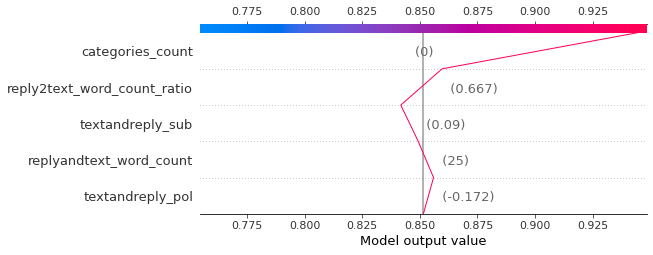

In [15]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

## For XGBoost

In [17]:
##### For RFC #####

# Use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(lambda x: xgb.predict_proba(x, validate_features=False), shap.kmeans(X_train, 10))  # apply k-means first to acclerate (but loss some accuracy)
shap_values = explainer.shap_values(X_test, nsamples=100)

In [18]:
# Plot the SHAP values of the first instance by force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

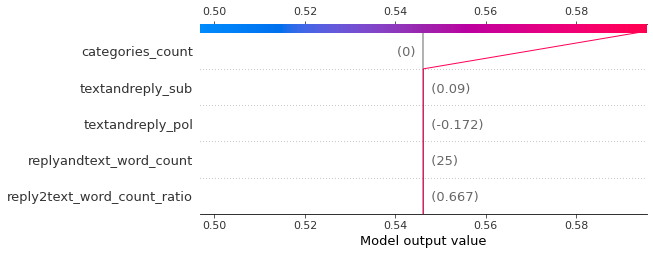

In [19]:
# Plot the SHAP values of the first instance by decision plot
shap.initjs()
shap.decision_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# [TODO 2] Discussion

1. Compare the importance of different features. Are the results similar among different models? Please address what you find below.


Accuracy 和 Loss 如下：
* SVM: Accuracy = 0.88 , Loss = 0.31 
* Random Forest: Accuracy = 0.96 , Loss = 0.1
* XGBoost: Accuracy = 0.96 , Loss = 0.54

(先將各個feature編號以方便討論, a: categories_count, b: reply2text_word_count_ratio, c: replyandtext_word_count, d: textandreply_pol, e: textandreply_sub)

各個模型中feature的重要性：
* SVM: c>a>e>b>d
* Random Forest: a>b>e>c>d
* XGBoost: a(其他feature為0)

各個feature force的方向:
* SVM: abcd | e
* Random Forest: abd | ce
* XGBoost: a |

結論：
* **對每個model來說重要的feature不同, 也沒有force是哪個方向重要性就高或低的關係**
* **XGBoost**的結果還蠻特別的, 雖然重要的只有一個feature, 但**準確率仍高達0.96**
* 原先在設計feature的時候認為b和c應該蠻接近的(b是text和reply的句子長度比例, c是text和reply的句子長度總和), 因為b和c兩個都是考慮句子長度, 但從RF可觀察到**兩個feature影響的方向不同**
* 與上面相似, 原先也認為d和e應該蠻接近的(d是text polarity和reply polarity的和, e是text subjectivity和reply subjectivity的和), 主要希望能觀察text和reply的情感極性和主觀性是否相同或相反, 因為這兩個數值都有正值和負值, 如果差異小(回覆是在同意推文者的推文)加起來就會是很大的值或很小的值, 如果差異大(回覆是在反對推文者的推文, 直觀上覺得這樣的tweet是fake的機會很大)就會是接近0的值, 但從SVM和RF的分析結果可發現**兩者的方向不同**


2. What’ll happen if we remove useless features according to the explanation results? Please do a simple experiment and address what you find.



* 根據上題, 移除相對來說最無用的 d: textandreply_pol
  * Accuracy在三個模型中的改變都小於1%
  * Loss在三個模型中有1%-2%的改變
  * 故我認為可以將重要性低的feature移除, 降低複雜度, 提升模型的解釋性

* 為了做比較, 有嘗試移除最有用的 a: categories_count
  * Accuracy在三個模型中的改變大約1%
  * Loss在三個模型中有大約3%-10%的改變
  * 故雖然改變量比 d: textandreply_pol 大, 但仍相差有限, 所以推論這三個模型robustness蠻高的



3. Without any constraint, please share one additional observation you find.

* 嘗試交換feature的順序,Accuracy和Loss以及important和
force的方向皆和原順序相同, 故**順序並不會影響訓練出的模型好壞與模型中各個feature的重要性**

